# Assignment 6. Basics of deep learning models
## General Assignment. Transfer learning

In this task, we will learn how to use transfer learning and fine-tuning techniques using the example of the task of recognizing hot dogs.

After completing this task, you will have the opportunity to participate in the Kaggle In-Class training competition and compare your results with other course participants.

Participation is completely optional and optional to complete the course. Instructions and details - at the end of the notebook!

This assignment requires GPU access.

It could be a GPU from NVidia on your machine, then it is recommended to install GPU-enabled PyTorch via Conda - https://pytorch.org/get-started/locally/

If you don't have a GPU, you can use [Google Colab] (https://colab.research.google.com/), which provides free access to GPUs in the cloud.

Google Colab setup tutorial:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
(You don't need to install Keras, our notebook will install PyTorch by itself)



Transfer learning and fine-tuning

One of the most important techniques in training networks is to use pre-trained weights on a more general task as a starting point, and then "train" them on a specific one.

This approach both speeds up learning and allows you to train efficient models on small datasets.

In this exercise, we will train a classifier that classify hot dogs from non-hot dogs!

This task requires access to the GPU, so it can be performed either on a computer with an NVidia GPU or in [Google Colab] (https://colab.research.google.com/).

In [109]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

#from google.colab import files

#!pip3 install -q torch torchvision
#!pip install -q Pillow==4.0.0

First, let's download the data with pictures. This will do the code in the next cell. The data will be split into two parts. On the training set, which will be stored in the ** train_kaggle ** folder, we will build our models, and on the test set ** test_kaggle ** we will predict the class to which the photo belongs (hot dog or not).

### If you are on Google Colab!

It can run notebooks with GPU access. They are not very fast, but they are free!
Each notebook gets its own environment with an available disk, etc.

After 90 minutes of inactivity, this environment disappears with all the data.
Therefore, we will have to download the data every time.

In [110]:
# Download train data
#!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
#!unzip -q "train.zip"

train_folder = "./Assignment_Data/train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
#!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
#!unzip -q "test.zip"

test_folder = "./Assignment_Data/test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


In [111]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
print(torch.cuda.is_available())
device = torch.device("cuda:0") # Let's make sure GPU is available!
x = torch.randint(1,100,(100,100))
x.device

True


device(type='cpu')

# Implementing your Dataset to load data

In this task, we will implement our own Dataset class for loading data. Goal is to load data from disk and generate a tensor with the network input, label and image ID (this will make it easier to prepare a submission for kaggle on test data).

Here is a link that explains well how to do this with an example: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Your Dataset should display the number of files in a folder as the number of samples and be able to display a tuple from a sample, a score by index and file name.
If the file name begins with the words 'frankfurter', 'chili-dog' or 'hotdog', the label is positive. Otherwise negative (zero).

And don't forget to support the ability to transform the input (the `transforms` argument), we'll need it!

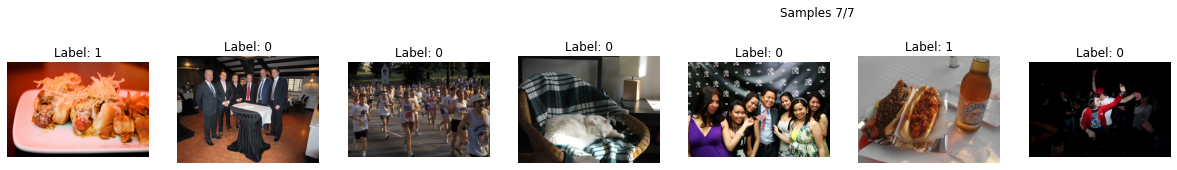

In [112]:
import pandas as pd


class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        filenames = [img for img in os.listdir(folder) if img.endswith(".jpg")]
        self.data = pd.DataFrame(filenames, columns=['filename'])
        self.data['label'] = ""
        self.data['label'] = self._choose_labels()
        self.path = folder

        # TODO: Your code here!

    def _choose_labels(self)->list:
        output = []
        tok_filenames = [s.split(sep="_")[0] for s in self.data['filename']]
        for n in tok_filenames:
            if n=="frankfurter" or n=="chili-dog" or n=="hotdog":
                output.append(1)
            else:
                output.append(0)
        return output


    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        if index >= len(self):
            raise Exception("Index too large")
        filename = self.data['filename'].iloc[index]
        filepath = os.path.join(self.path, filename)
        img = Image.open(filepath)
        y = self.data['label'].iloc[index]

        # apply transformation if it exists
        if self.transform is not None:
            img = self.transform(img)

        return img, y, index


def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

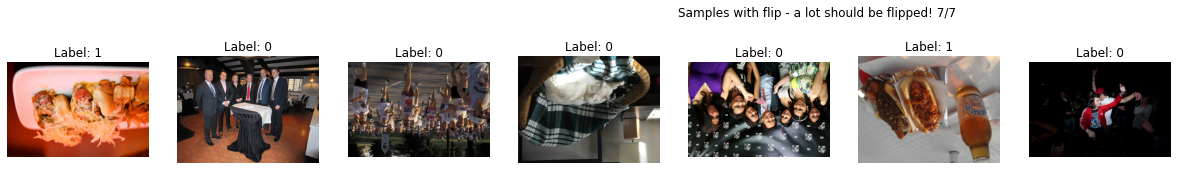

In [113]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Create Dataset for the training

And we divide it into train and validation.
We will train the model on train, check its quality for validation, and we will hold the Kaggle In-Class competition on photos from the test_kaggle folder.

In [114]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [115]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Our usual training functions

In [116]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    acc = [torch.mean((model(batch[0].to(device)).argmax(axis=1) == batch[1].to(device)).float()) for batch in loader]
    acc = torch.mean(torch.Tensor(acc))
    return acc


# Using a pretrained network

Most often, the pre-trained network is a network trained on ImageNet data with 1M images and 1000 classes.

PyTorch includes such trained networks for various architectures (https://pytorch.org/docs/stable/torchvision/models.html)
We will be using ResNet18.

First, let's see what the already trained network gives out in our pictures. That is, let's see which of the 1000 classes the network assigns them to.

Run the model on 10 random images from the dataset and output them together with the classes with the highest probability.
There is already code in the code that generates the correspondence between the indices in the output vector and the ImageNet classes.

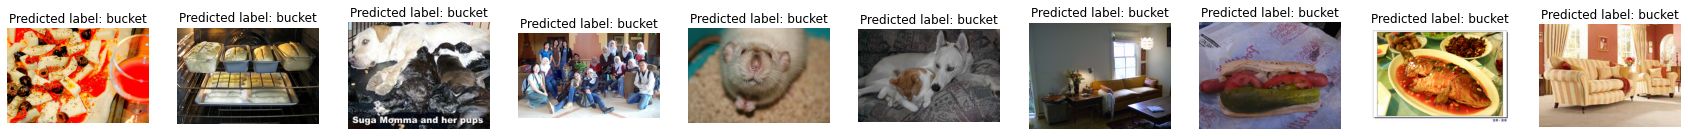

In [117]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    # TODO: Process it to return dict of class index to name
    # Thats what happens already?
    return { int(k): v[-1] for k, v in classes.items()}

model = models.resnet18(pretrained=True)
model = model.to(device=device)

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts
indices = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)


def test_prediction(model, images, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    classes = load_imagenet_classes()
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))
    for i, index in enumerate(display_indices):
        img, _, _ = orig_dataset[index]
        x, _, _ = images[index]

        pred = model(x.unsqueeze(0).to('cuda')) # get prediction
        plt.subplot(1,count,i+1)
        plt.title("Predicted label: %s" % classes[pred[0].argmax().item()])
        plt.imshow(img)
        #plt.imshow(x.permute(1,2,0))
        plt.grid(False)
        plt.axis('off')

test_prediction(model, train_dataset, indices)
#visualize_samples(orig_dataset, indices,"Original",len(indices))

In [118]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Transfer learning - train only the last layer

There are several options for transfer learning, we will try the main ones.
The first option is to replace the last layer with a new one and train only it, freezing others.



In [119]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for param in model.parameters(): # Freezes all layers
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)

model = model.cuda() # Just to be absolutely sure we use cuda

parameters = model.fc.parameters()  # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.380303, Train accuracy: 0.826229, Val accuracy: 0.917361
Average loss: 0.210172, Train accuracy: 0.915015, Val accuracy: 0.938889


In [120]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Transfer learning - train the whole model

The second option is to replace the last layer with a new one in the same way and train the entire model.

In [121]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.cuda()

parameters = model.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.297906, Train accuracy: 0.871572, Val accuracy: 0.935764
Average loss: 0.137250, Train accuracy: 0.952756, Val accuracy: 0.943056


In [130]:
# # delete old model to free cuda memory
if 'model' in locals():
    del model
import gc
gc.collect()
torch.cuda.empty_cache()

# Transfer learning - different learning rates for different layers

And finally, the last option that we will consider is to use different learning rates for new and old layers.

In [123]:
import torch.nn as nn
import torch.optim as optim

model_conv = models.resnet18(pretrained=True)
# TODO: Add a new output layer
model_conv.fc = nn.Linear(model_conv.fc.in_features, 2)
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model_conv = model_conv.cuda()

param_list = ['fc.weight', 'fc.bias']
params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in param_list, model_conv.named_parameters()))))
base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in param_list, model_conv.named_parameters()))))
parameters = [{'params': params, 'lr':0.001},
              {'params': base_params, 'lr':0.0001}]

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD( parameters, momentum=0.9)
loss_history, train_history, val_history = train_model(model_conv, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.373654, Train accuracy: 0.826772, Val accuracy: 0.922917
Average loss: 0.196206, Train accuracy: 0.926690, Val accuracy: 0.937500
Average loss: 0.161675, Train accuracy: 0.940266, Val accuracy: 0.941319
Average loss: 0.151328, Train accuracy: 0.945153, Val accuracy: 0.944097
Average loss: 0.140288, Train accuracy: 0.946783, Val accuracy: 0.943750


# Visualizing model metrics and errors

Let's try to see where the model goes wrong - visualizing false positives and false negatives.

To do this, we'll run the model through all the examples and compare it to the ground truth.

In [124]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    ground_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    subsampler = SubsetSampler(indices)
    predictions = []
    ground_truth = []
    for s in subsampler:
        img, g_truth, _ = dataset[s]
        ground_truth.append(g_truth)
        with torch.no_grad():
            p = model(img.unsqueeze(0).to('cuda'))
            p = np.argmax(p.cpu())
            predictions.append(p)

    return predictions, ground_truth

predictions, gt = evaluate_model(model_conv, train_dataset, val_indices)

And now we can render false positives and false negatives.

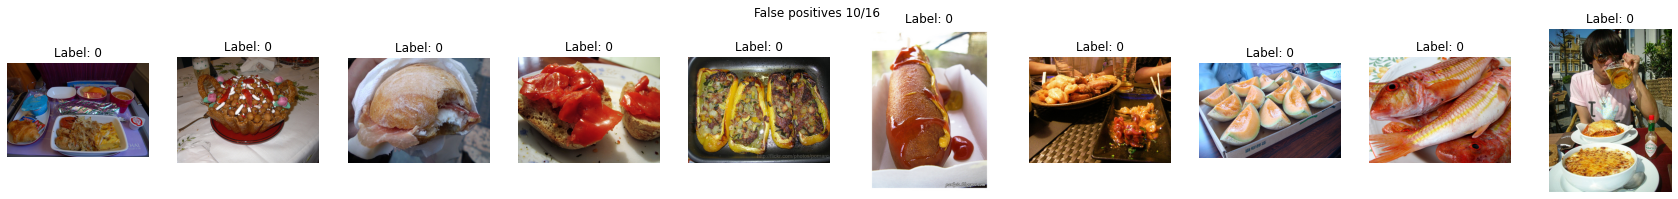

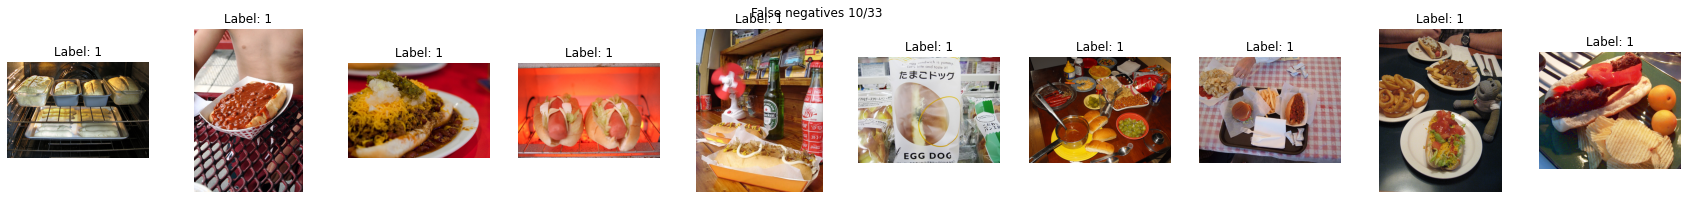

In [125]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = [img_index for index, img_index in enumerate(val_indices) if predictions[index]==1 and gt[index]==0]
visualize_samples(orig_dataset, false_positive_indices, "False positives")

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = [img_index for index, img_index in enumerate(val_indices) if predictions[index]==0 and gt[index]==1]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


In [126]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    # TODO: Implement this function!
    # We did this already it in the assignment1
    precision = metrics.precision_score(ground_truth,prediction)
    recall = metrics.recall_score(ground_truth,prediction)
    f1 = metrics.f1_score(ground_truth,prediction)
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))
print(f"F1: {f1:4.3f}, P: {precision:4.3f}, R: {recall:4.3f}")

F1: 0.919, P: 0.946, R: 0.894
F1: 0.919, P: 0.946, R: 0.894


# What will happen at the end you already understood

Train the best model based on `resnet18`, changing only the training process.
Choose the best model by F1 score.

As always, don't forget:
- more agmentation!
- enumeration of hyperparameters
- various optimizers
- what layers to tune
- learning rate annealing
- what era to stop at

Our goal is to bring the F1 score on the validation set to a value greater than **0.93**.

In [132]:
# TODO: Train your best model!
best_model = models.resnet18(pretrained=True)
best_model.fc = nn.Linear(best_model.fc.in_features, 2)
# best_model.fc = nn.Sigmoid()
best_model = best_model.cuda()

loss = nn.CrossEntropyLoss()

In [133]:
# optimizers = [optim.SGD(best_model.parameters(), lr=0.001, momentum=0.9),optim.AdamW(best_model.parameters(), lr=0.001)]
optimizer = optim.SGD(best_model.parameters(), lr=0.001, momentum=0.9)

In [134]:
if 'model' in locals():
    del model
if 'model_conv' in locals():
    del model_conv
import gc
gc.collect()
torch.cuda.empty_cache()

Average loss: 0.334318, Train accuracy: 0.837904, Val accuracy: 0.938194
Average loss: 0.141363, Train accuracy: 0.948140, Val accuracy: 0.949306
Average loss: 0.103482, Train accuracy: 0.963617, Val accuracy: 0.949306
Average loss: 0.069170, Train accuracy: 0.979365, Val accuracy: 0.949653
Average loss: 0.050468, Train accuracy: 0.985881, Val accuracy: 0.949306
Average loss: 0.034481, Train accuracy: 0.992941, Val accuracy: 0.947917
Average loss: 0.023930, Train accuracy: 0.997013, Val accuracy: 0.958333
Average loss: 0.019829, Train accuracy: 0.997828, Val accuracy: 0.956250
Average loss: 0.014329, Train accuracy: 0.998914, Val accuracy: 0.952431
Average loss: 0.011254, Train accuracy: 0.999728, Val accuracy: 0.956250
F1: 0.933, P: 0.927, R: 0.939


<BarContainer object of 2 artists>

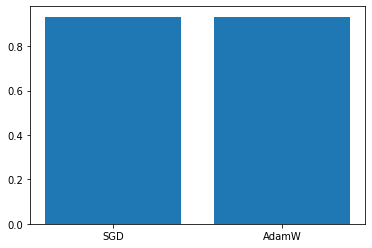

In [135]:
def eval(model, dataset, val_indices):
    # Let's check how it performs on validation set!
    predictions, ground_truth = evaluate_model(model, dataset, val_indices)
    precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
    print(f"F1: {f1:4.3f}, P: {precision:4.3f}, R: {recall:4.3f}")

    # TODO: Visualize training curve for the best model
    # plt.subplot(1,2,1)
    # plt.plot(range(1,len(train_history)+1),train_history, label='train_history')
    # plt.plot(range(1,len(val_history)+1),val_history, label='val_history')
    # plt.legend(loc='best')
    # plt.xlim(1,len(train_history)+1)
    # plt.title("Accuracy")
    # plt.subplot(1,2,2)
    # plt.plot(range(1,len(loss_history)),loss_history, label='loss_history')
    # plt.legend(loc='best')
    # plt.xlim(1,len(train_history)+1)
    # plt.title("Loss")
    # plt.show()

    return precision,recall,f1

loss_history, train_history, val_history = train_model(best_model, train_loader, val_loader, loss, optimizer, 10)
eval(best_model,train_dataset,val_indices)

In [140]:
# torch.save(best_model.state_dict(),'./Assignment_Data/sgd_model_weights.pth')
# saved for
#best_model = models.resnet18(pretrained=True)
#best_model.fc = nn.Linear(best_model.fc.in_features, 2)
#best_model = best_model.cuda()
#
# loss = nn.CrossEntropyLoss()
# # optimizers = [optim.SGD(best_model.parameters(), lr=0.001, momentum=0.9),optim.AdamW(best_model.parameters(), lr=0.001)]
# optimizers = [optim.SGD(best_model.parameters(), lr=0.001, momentum=0.9)]

In [141]:
# best_model.load_state_dict(torch.load('./Assignment_Data/sgd_model_weights.pth'))

<All keys matched successfully>

In [ ]:
best_model

## Visualize the errors of the best model

In [ ]:
# TODO Visualize false positives and false negatives of the best model on the validation set

# Optional task

Join the Kaggle In-Class Hot Dog Recognition Challenge!
This competition is made specifically for the course and only those who take the course participate in it.

In it, participants compete as trained models, uploading predictions of their models on a test sample to the site. Test dataset labeling is not available to participants.
More details about the competition rules below.

Here you can already use other basic architectures besides `resnet18`, and ensembles, and other tricks for training models.

Here is the link to the competition:
https://www.kaggle.com/c/hotdogornot

In [ ]:
image_id = []
predictions = []
model.eval()
for x,_,id_img in test_loader:
    # TODO: Write a code to predict the tags (1 = hot dog present, 0 = no hot dog)
    # The code should return a list of image id and predictions label
    # image id is the name of the image file, for example '10000.jpg'
    pass

In [ ]:
# This is how you can create a csv file and then upload it to kaggle
# Expected csv file format:
# image_id,label
# 10000.jpg,1
# 10001.jpg,1
# 10002.jpg,0
# 10003.jpg,1
# 10004.jpg,0

with open('subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,predictions))

In [ ]:
# And so you can download the file from Google Colab
# files.download('subm.csv')

### A small introduction to Kaggle for those who have not heard of this platform before
At its core, Kaggle is a machine learning competition platform. It appeared in 2010 and, perhaps, has become the most popular and well-known of all existing machine learning platforms. I must say that Kaggle is not only a competition, but also a community of people passionate about machine learning. In 2017 the number of registered users exceeded one million. There are also tutorials, the ability to ask questions, share code and ideas.

### How is the competition going?
Typically, participants download train data to make predictions on test data. The training set contains both the data itself and the correct labels (dependent variable values) so that the model can be trained. But the test data does not contain an answer - and our goal is to predict labels from the available data. The file with the answers for each observation from the test sample is uploaded to Kaggle and evaluated in accordance with the chosen competition metric, and the result is public and shown in the general table (also called the leaderboard) - so that there is a desire to compete and create an even stronger model. In the "real" competitions that take place on Kaggle, there is also a cash reward for those participants who take the first places on the leaderboard. For example, in [this] (https://www.kaggle.com/c/zillow-prize-1#description) competition, the first place winner earned about $1,000,000.

The test data is divided randomly in some proportion. And while the competition is going on, the leaderboard shows the points and the rating of the participants for only one part (Public Leaderboard). But when the competition ends, the rating of the participants is compiled according to the second part of the test data (Private Leaderboard). And you can often see how people who took the first places on the public part of the test data are far from the first on the closed part of the test data. Why is this done? There are several reasons, but perhaps the most fundamental is the idea of ​​underfitting-overfitting. It is always possible that our model is tuned to a specific sample, but how will it behave on data that it has not yet seen? The division of test data into public and hidden parts is done in order to select models that have a large generalizing ability. One of the slogans of the competition participants was "Trust your local cross-validation" (Trust your CV!). There is a very big temptation to evaluate your model on the public part of the leaderboard, but the best strategy is to choose the model that gives the best metric for cross-validation on a training set.

In our competition, the public part of the leaderboard is 30%, and the hidden part is 70%. You can make up to two attempts per day, and attempts will be scored on an F1 score. Good luck and trust your local validation! At the end of the competition, you will have the opportunity to choose 2 out of all the attempts made - the best of these two will be credited to you on the hidden part of the test data